# Description
This will focus on using classic regression models to model the data, instead of time series methods. 

#### NOTE: As described in EDA notebook, "Pseudo_ts" is concatenation of data from locally adjacent ski resorts (e.g., all resorts in Colorado) into a single timeseries.
# Imports

In [1]:
# data wrangling
import numpy as np
import pandas as pd
import os.path
from sklearn.preprocessing import MinMaxScaler

# viz
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import arviz as az

# modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
import pystan

%load_ext autoreload
%autoreload 2
# project code
from project_utils import project_utils as util

# Parameters

In [2]:
alt.renderers.enable(embed_options={'theme': 'vox'})
alt.data_transformers.disable_max_rows()
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
plt.rc('figure', figsize=(11.0, 7.0))

# Load Data

In [3]:
all_data_path = r'../../data/snow_data_clean.parquet'

In [4]:
long_series_df = pd.read_parquet(all_data_path)
assert long_series_df.base.isna().sum()==0
month_ts_df = long_series_df.pipe(util.resample_by_month, time_col='pseudo_ts')
# start analysis with just CO resorts
co_base_ts = (month_ts_df
              .query('state=="colorado"')
              .sort_values(by='pseudo_ts')
              .dropna(how='all')
             )
long_series_df.head()

,dayofyr,timestamp,base,station,snowfall,ski_yr,state,region,pseudo_ts_delt,pseudo_ski_yr,pseudo_ts,basecol_interpolated
11085,137.0,2016-01-10,0.000000,Mt. Holiday,2.0,5.0,michigan,Other,324.0,-31.0,1692-01-10,True
11086,138.0,2016-01-11,-2.320142,Mt. Holiday,3.0,5.0,michigan,Other,324.0,-31.0,1692-01-11,True
11087,139.0,2016-01-12,-2.320142,Mt. Holiday,5.0,5.0,michigan,Other,324.0,-31.0,1692-01-12,True
11088,140.0,2016-01-13,6.737995,Mt. Holiday,0.0,5.0,michigan,Other,324.0,-31.0,1692-01-13,False
11089,141.0,2016-01-14,10.000000,Mt. Holiday,0.0,5.0,michigan,Other,324.0,-31.0,1692-01-14,False


# Feature Engineering

In [5]:
def add_month(data: pd.DataFrame) -> pd.DataFrame:
    return data.assign(month=lambda x:
                       x.pseudo_ts.dt.month)

def add_diff(data: pd.DataFrame) -> pd.DataFrame:
    return (data
            .assign(delta_base=lambda x: x.base.diff(1))
            .fillna(0)
            .drop(columns=['base'])
           )

def ohe(data: pd.DataFrame, col: str) -> pd.DataFrame:
    return pd.concat([data.drop(columns=[col]),
                      pd.get_dummies(data[col],
                                     prefix=col)],
                     axis=1)

def add_month_x_snowfall(data: pd.DataFrame) -> pd.DataFrame:
    months = [col for col in data.columns
              if 'month_' in col]
    combos_df = pd.concat([pd.Series(data.snowfall * data[month],
                                     name='snowfall_x_' + month)
                           for month in months], axis=1)
    return pd.concat([data, combos_df], axis=1)

def cleaner(data: pd.DataFrame) -> pd.DataFrame:
    """ski_yr is needed for test/train split"""
    data = data.query('basecol_interpolated==True')
    bad_cols = ['dayofyr', 'station', 'state', 'pseudo_ski_yr',
                'timestamp', 'basecol_interpolated', 'pseudo_ts',
                'pseudo_ts_delt'
               ]
    return data.drop(columns=bad_cols)

In [120]:
data = (long_series_df.pipe(add_month)
        .pipe(add_diff)
        #.pipe(ohe, 'region')
        .pipe(ohe, 'month')
        .pipe(add_month_x_snowfall)
        .pipe(cleaner)
)
data.head()

,snowfall,ski_yr,region,delta_base,month_1,month_2,month_3,month_4,month_5,month_6,...,snowfall_x_month_3,snowfall_x_month_4,snowfall_x_month_5,snowfall_x_month_6,snowfall_x_month_7,snowfall_x_month_8,snowfall_x_month_9,snowfall_x_month_10,snowfall_x_month_11,snowfall_x_month_12
11085,2.0,5.0,Other,0.000000,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11086,3.0,5.0,Other,-2.320142,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11087,5.0,5.0,Other,0.000000,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31350,0.0,5.0,Other,-1.652098,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31351,0.0,5.0,Other,0.000001,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

The evolution of snow base depth over time depends (not 1:1; a foot of powder is only a few inches of packed powder) on new snowfall and melting of old snow. I will start by modeling as a simple timeseries, and then include new snowfall as a predictor variable.

## Modeling Setup
I will use regular cross validation.

In [62]:
def split_xy(df: pd.DataFrame) -> (np.array, np.array):
    """splits data into X and y arrays
    drops columns used in train_test_split before this func"""
    df = df.drop(columns=['ski_yr', 'region'])
    return (df.drop(columns=['delta_base']).to_numpy(),
            df.delta_base.to_numpy().reshape(-1))


def train_test_split(data: pd.DataFrame) -> (np.array, np.array, np.array, np.array):
    """splits data
    Output: (X_train, y_train, X_test, y_test)
    """
    train, test = data.query("ski_yr!=8"), data.query("ski_yr==8")
    return (*split_xy(train), *split_xy(test))

In [85]:
def get_results(data: pd.DataFrame, region: str) -> dict:
    X_train, y_train, X_test, y_test = train_test_split(data)
    lin_regr = ElasticNetCV(cv=5)
    
    lin_regr.fit(X_train, y_train)
    lin_resid = y_test - lin_regr.predict(X_test)
    results = {}
    results['r2'] = lin_regr.score(X_test, y_test)
    lin_regr_resids = pd.DataFrame(lin_resid)
    results['mse'] = (lin_regr_resids**2).sum()[0]
    results['mae'] = lin_regr_resids.sum().abs()[0]
    results_df = pd.DataFrame(results, index=[region])
    col_list = [c for c in data.columns 
                if c not in ['ski_yr', 'region', 'delta_base']]
    coefs_df = pd.DataFrame(data=lin_regr.coef_.reshape(1,-1), 
                            columns=col_list, index=[region])
    results_df = pd.concat([results_df, coefs_df], axis=1)
    return results_df

In [86]:
colo = (get_results(data[data.region=="Colorado"], 'Colorado'))

In [88]:
regional_regression = pd.concat([get_results(data.query("region==@region"), 
                                             region)
                                 for region in data.region.unique()])

In [95]:
regional_regression.mean().to_frame()

,0
r2,0.115945
mse,17167.100144
mae,61.781283
snowfall,0.003193
month_1,0.115638
month_2,0.076826
month_3,-0.026375
month_4,-0.102577
month_5,-0.432486
month_6,-0.674480


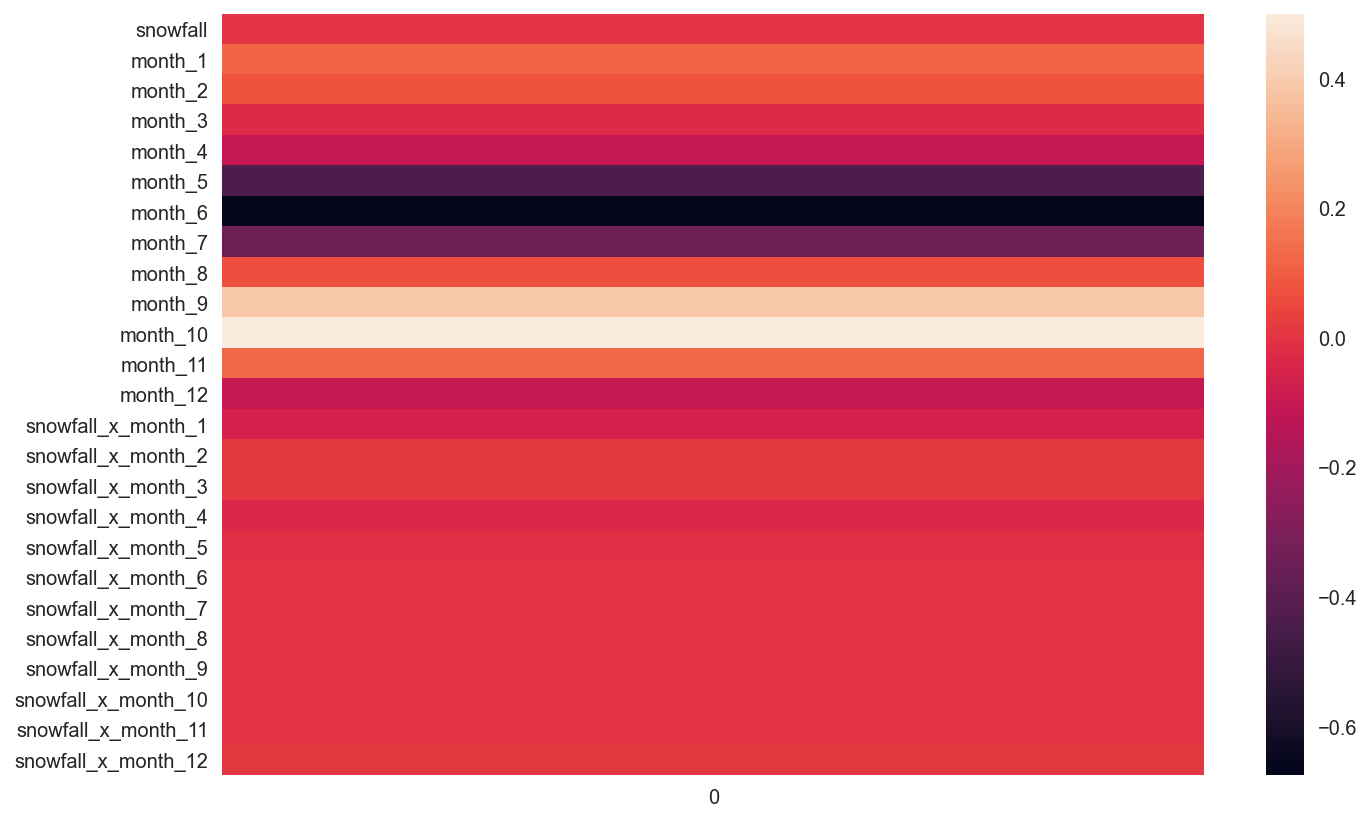

In [98]:
sns.heatmap(data=regional_regression.iloc[:,3:].mean().to_frame());

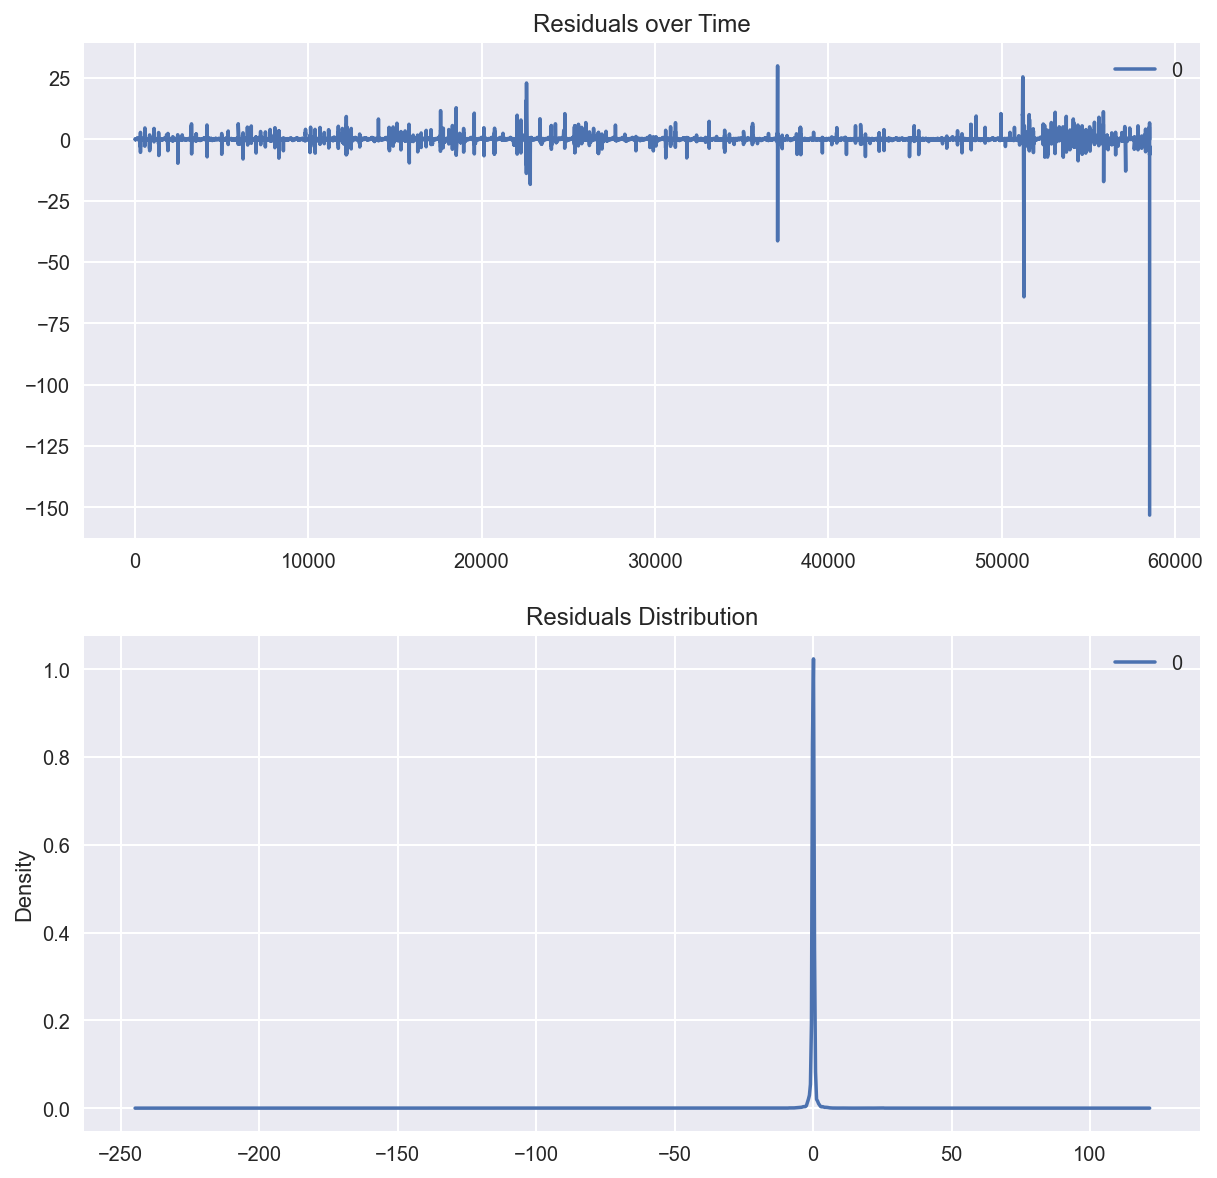

                  0
count  58542.000000
mean       0.004757
std        1.532467
min     -153.254441
25%       -0.183863
50%        0.011916
75%        0.221417
max       29.939040


In [12]:
lin_regr_resids = pd.DataFrame(lin_resid)
util.resid_plotter(lin_regr_resids)

there does not appear to be a trend. The errors are not exactly normal. The residuals vary cyclicly so an ARCH  model may be useful.

In [ ]:
plt.figure(figsize=(8,10))
sns.boxplot(data=snow_beta_df, x='region', y='beta', showfliers=False)
plt.title('Snowfall beta: Estimate of how an inch of snowfall will affect base depth');

In [ ]:
snow_betas_linear_df.to_parquet(r"../../data/processed/snow_betas_from_regr.parquet")

# Bayesian Linear Model
I want to add priors to the model that snowfall should only result in increases in base depth, and monthly effects should only result in reduction (i.e., monthly effect should measure strength of melting.) A bayesian model allows for this.

In [121]:
columns = data.columns
cols1 = [c for c in columns if "snowfall" not in c]
cols2 = [c for c in columns if c not in cols1]
data = data[cols1 + cols2]
data.head()

,ski_yr,region,delta_base,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,snowfall_x_month_3,snowfall_x_month_4,snowfall_x_month_5,snowfall_x_month_6,snowfall_x_month_7,snowfall_x_month_8,snowfall_x_month_9,snowfall_x_month_10,snowfall_x_month_11,snowfall_x_month_12
11085,5.0,Other,0.000000,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11086,5.0,Other,-2.320142,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11087,5.0,Other,0.000000,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31350,5.0,Other,-1.652098,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31351,5.0,Other,0.000001,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
stan_model = """
data {
    // input data passed from Python
    int<lower=0> N;   // number of data observations
    int<lower=0> K;   // number of predictors
    matrix[N, K] x;   // predictor matrix
    vector[N] y;      // response vector
    int snow_start;   // column start with snowfall data 
    int snow_end;     // column end with snowfall data
    int month_start;  // column start with month data 
    int month_end;    // column end with month data

parameters {
    real alpha;
    vector[N] beta;
    for (n in snow_start:snow_end) {
        real<lower=0>  beta[n];
    }  // ~snowfall~
    for (n in month_start:month_end) {
        real<upper=0>  beta[n];
    }  // ~melting~
    real<lower=0> sigma; // must be +ve
    }
model {
    // priors set with an eye to data
    alpha ~ normal(0, 2);
    beta ~ normal(0, 3);
    sigma ~ cauchy(0, 10); // half Cauchy
    y ~ normal(alpha + beta * x, sigma);
"""
print(stan_model)


data {
    // input data passed from Python
    int<lower=0> N;   // number of data observations
    int<lower=0> K;   // number of predictors
    matrix[N, K] x;   // predictor matrix
    vector[N] y;      // response vector
    int snow_start;   // column start with snowfall data 
    int snow_end;     // column end with snowfall data
    int month_start;  // column start with month data 
    int month_end;    // column end with month data

parameters {
    real alpha;
    vector[N] beta;
    for (n in snow_start:snow_end) {
        real<lower=0>  beta[n];
    }  // ~snowfall~
    for (n in month_start:month_end) {
        real<upper=0>  beta[n];
    }  // ~melting~
    real<lower=0> sigma; // must be +ve
    }
model {
    // priors set with an eye to data
    alpha ~ normal(0, 2);
    beta ~ normal(0, 3);
    sigma ~ cauchy(0, 10); // half Cauchy
    y ~ normal(alpha + beta * x, sigma);

